In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
CIFAR100_TRAIN_MEAN = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
CIFAR100_TRAIN_STD = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
train_transform = transforms.Compose(
    [transforms.Resize([224, 224]),
    # torchvision.transforms.RandomCrop(32, padding=4), 
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_TRAIN_MEAN, CIFAR100_TRAIN_STD)])
test_transform = transforms.Compose(
    [transforms.Resize([224, 224]), 
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_TRAIN_MEAN, CIFAR100_TRAIN_STD)])

batch_size = 16

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = list(range(100))
classes = [str(num) for num in classes]
print(classes)

100%|██████████| 169001437/169001437 [00:13<00:00, 12891562.29it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


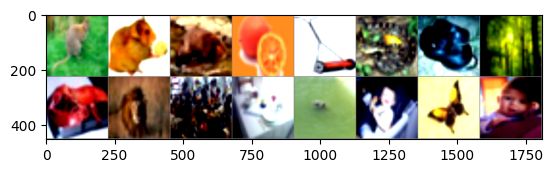

38    36    4     53    41    78    78    33    45    43    33    84    55    11    14    2    


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
import torch.nn as nn
import math
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
import torch

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)



class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)


        # self.ca = ChannelAttention(planes)
        # self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # out = self.ca(out) * out
        # out = self.sa(out) * out


        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        # self.ca = ChannelAttention(planes * self.expansion)
        # self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        # out = self.ca(out) * out
        # out = self.sa(out) * out

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=100, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        # add attention mechanism before the first block
        self.ca = ChannelAttention(self.inplanes)
        self.sa = SpatialAttention()

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        # add attention mechanism after the last block
        self.ca1 = ChannelAttention(self.inplanes)
        self.sa1 = SpatialAttention()

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.ca(x) * x
        x = self.sa(x) * x

        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.ca1(x) * x
        x = self.sa1(x) * x


        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x


# def _resnet(arch, block, layers, pretrained, progress, **kwargs):
#     model = ResNet(block, layers, **kwargs)
#     if pretrained:
#         state_dict = load_state_dict_from_url(model_urls[arch],
#                                               progress=progress)
#         new_state_dict = model.state_dict()
#         new_state_dict.update(state_dict)
#         model.load_state_dict(new_state_dict)
#     return model

def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = torch.load('cifar100_resnetCBAM_epoch20.pth')
        new_state_dict = model.state_dict()
        new_state_dict.update(state_dict)
        model.load_state_dict(new_state_dict)
    return model



def resnet18(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNeXt-50 32x4d model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNeXt-101 32x8d model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [7]:
import torch.nn as nn
model = resnet18(pretrained = True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, num_classes = 100)
# state_dict = torch.load('cifar10_1_net.pth')
# new_state_dict = model.state_dict()
# new_state_dict.update(state_dict)
# model.load_state_dict(new_state_dict)
# model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
# model.maxpool = nn.Identity()
model = model.to(device)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)

In [9]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (ca): ChannelAttention(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (relu1): ReLU()
    (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (sigmoid): Sigmoid()
  )
  (sa): SpatialAttention(
    (conv1): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [10]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.076
[2,  2000] loss: 0.063
[3,  2000] loss: 0.059
[4,  2000] loss: 0.055
[5,  2000] loss: 0.052
[6,  2000] loss: 0.050
[7,  2000] loss: 0.047
[8,  2000] loss: 0.047
[9,  2000] loss: 0.043
[10,  2000] loss: 0.043
Finished Training


In [11]:
PATH = './cifar100_resnetCBAM_epoch30.pth'
torch.save(model.state_dict(), PATH)

In [12]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

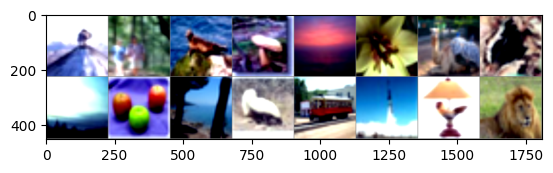

GroundTruth:  49    33    72    51    71    92    15    14    23    0     71    75    81    69    40    43   


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
model.load_state_dict(torch.load('./cifar100_resnet_epoch5.pth'))
model.eval()
# model.to('cpu')
# outputs = model(images)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{predicted[j]:5d}'
                              for j in range(batch_size)))

Predicted:     30    33    30    51    23    79    19     7    23    57    71    75    90    69    40    43


In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
sum_correct = 0
total_pred1 = 0
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    sum_correct += float(correct_count)
    total_pred1 += total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
print('total accuracy: ', sum_correct/total_pred1)

Accuracy for class: 0     is 88.0 %
Accuracy for class: 1     is 81.0 %
Accuracy for class: 2     is 54.0 %
Accuracy for class: 3     is 43.0 %
Accuracy for class: 4     is 53.0 %
Accuracy for class: 5     is 65.0 %
Accuracy for class: 6     is 76.0 %
Accuracy for class: 7     is 65.0 %
Accuracy for class: 8     is 79.0 %
Accuracy for class: 9     is 79.0 %
Accuracy for class: 10    is 53.0 %
Accuracy for class: 11    is 43.0 %
Accuracy for class: 12    is 78.0 %
Accuracy for class: 13    is 59.0 %
Accuracy for class: 14    is 59.0 %
Accuracy for class: 15    is 69.0 %
Accuracy for class: 16    is 64.0 %
Accuracy for class: 17    is 79.0 %
Accuracy for class: 18    is 62.0 %
Accuracy for class: 19    is 62.0 %
Accuracy for class: 20    is 83.0 %
Accuracy for class: 21    is 79.0 %
Accuracy for class: 22    is 60.0 %
Accuracy for class: 23    is 83.0 %
Accuracy for class: 24    is 80.0 %
Accuracy for class: 25    is 59.0 %
Accuracy for class: 26    is 55.0 %
Accuracy for class: 27    is